In [1]:
from trikde.pdfs import DensitySamples, IndependentLikelihoods
from trikde.triangleplot import TrianglePlot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
means = [0.55, 0.8, 0.45]
sigma_11 = 0.15 ** 2
sigma_22 = 0.2 ** 2
sigma_33 = 0.12 ** 2
sigma_12 = - (0.09 ** 2)
sigma_23 = 0.08 ** 2
sigma_13 = 0.07 ** 2

cov = np.array([[sigma_11, sigma_12, sigma_13], 
       [sigma_12, sigma_22, sigma_23], 
       [sigma_13, sigma_23, sigma_33]])
nsamples = 1000
samples = np.random.multivariate_normal(means, cov, nsamples)
assert np.linalg.det(cov) > 0

param_names = ['p1', 'p2', 'p3']
weight_list = None
param_ranges = [[0., 1.25], [0., 1.25], [0., 1.25]]
nbins = 15
use_kde = False
density_samples_no_kde = DensitySamples(samples, param_names, weight_list, param_ranges, 
                                        nbins=nbins, use_kde=False)
density_samples_with_kde = DensitySamples(samples, param_names, weight_list, param_ranges, nbins=nbins, 
                                          use_kde=True)
# the kernel density likelihood will in general depend on the bandwidth; it is difficult to know a priori what
# value is appropriate, especially for non-gaussian distributions
density_samples_with_kde_2 = DensitySamples(samples, param_names, weight_list, param_ranges, nbins=nbins, 
                                          use_kde=True, bandwidth_scale=0.1)

independent_densities_no_kde = IndependentLikelihoods([density_samples_no_kde])
independent_densities_with_kde = IndependentLikelihoods([density_samples_with_kde])
independent_densities_with_kde_2 = IndependentLikelihoods([density_samples_with_kde_2])

## Plot the distributions

Text(0, 0.5, 'custom y label')

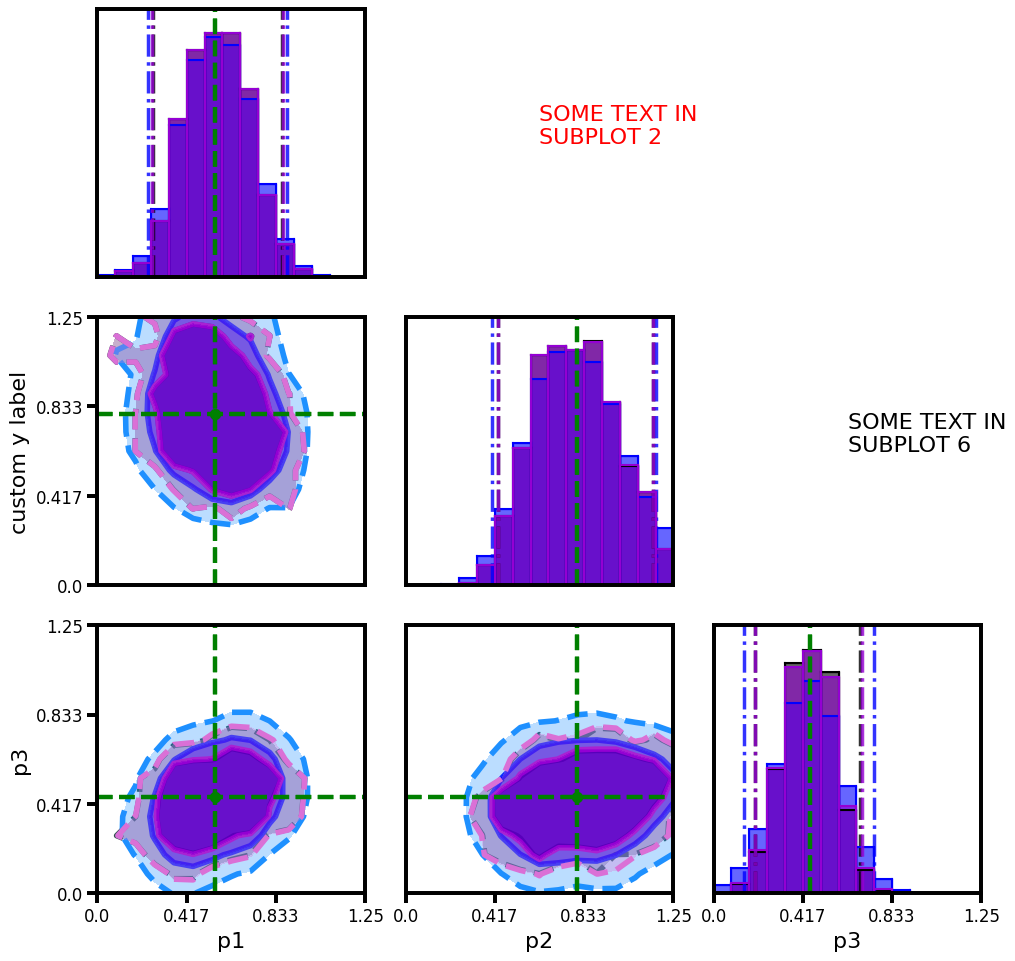

In [3]:
truths = {'p1': means[0], 'p2': means[1], 'p3': means[2]}
pdf_list = [independent_densities_no_kde, 
                        independent_densities_with_kde, 
                        independent_densities_with_kde_2]
triplot = TrianglePlot(pdf_list)
axes_list = triplot.make_triplot(truths=truths)

# triplot.make_triplot returns a list of the subplots, which can be individually manipulated
axes_list[1].annotate('SOME TEXT IN\nSUBPLOT 2', xy=(0.5, 0.5), xycoords='axes fraction', color='r', fontsize=16)
axes_list[5].annotate('SOME TEXT IN\nSUBPLOT 6', xy=(0.5, 0.5), xycoords='axes fraction', color='k', fontsize=16)
axes_list[3].set_ylabel('custom y label')

## Multiplying indepdent pdfs

### The DensitySamples class represents a single independent likelihood. If a list of these classes is passed to IndepdendentLikelihoods, then each instance of DensitySamples will be interpreted as an independent pdf and they will be multiplied together

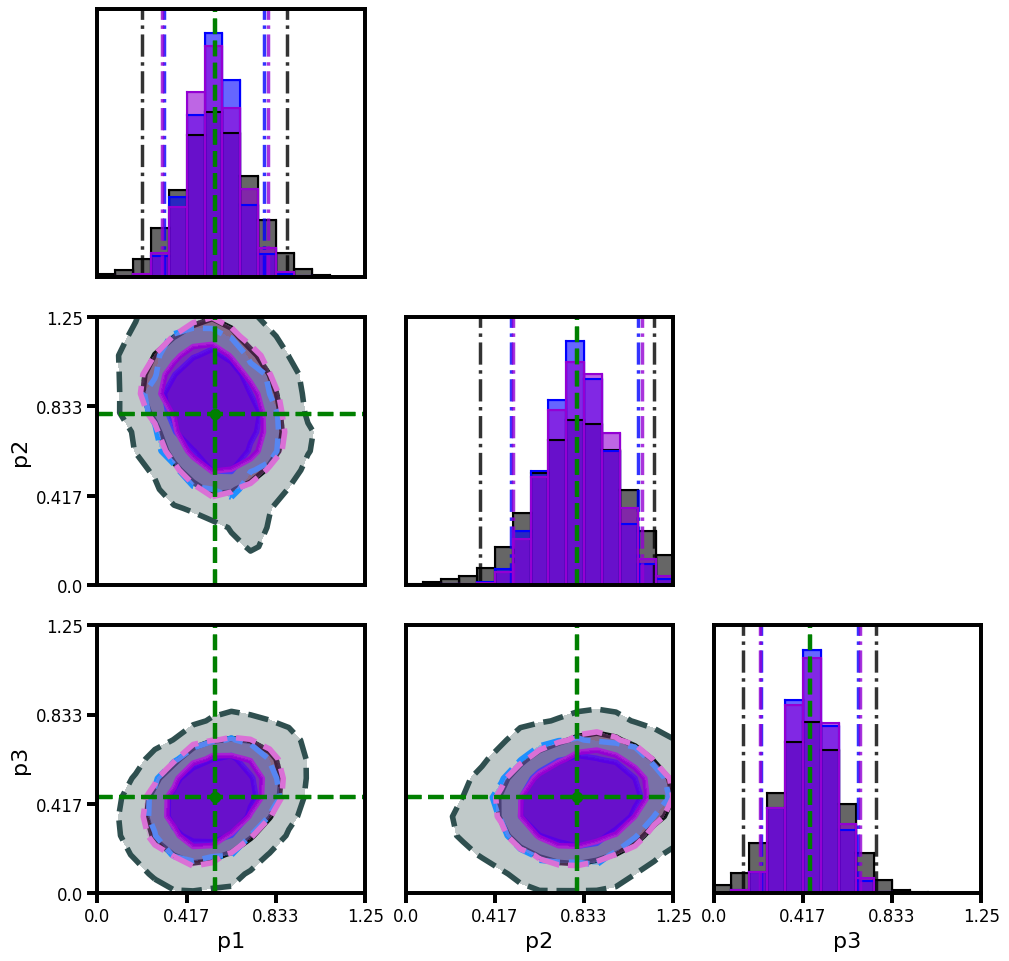

In [4]:
nsamples = 1000

inv = np.linalg.inv(cov)
cov_product = np.linalg.inv(inv)
samples = np.random.multivariate_normal(means, cov_product, nsamples)
pdf = DensitySamples(samples, param_names, weight_list, param_ranges, nbins=nbins, 
                                          use_kde=True)

inv = 2 * np.linalg.inv(cov)
cov_product = np.linalg.inv(inv)
samples_product = np.random.multivariate_normal(means, cov_product, nsamples)
pdf_product = DensitySamples(samples_product, param_names, weight_list, param_ranges, nbins=nbins, 
                                          use_kde=True)

independent_likelihood_single = IndependentLikelihoods([pdf])
independent_likelihood_product_from_samples = IndependentLikelihoods([pdf_product])
independent_likelihood_product_from_pdfs = IndependentLikelihoods([pdf, # we pass it twice and it gets multiplied
                                                                    pdf])

pdf_list = [independent_likelihood_single, 
            independent_likelihood_product_from_samples, 
            independent_likelihood_product_from_pdfs]
triplot = TrianglePlot(pdf_list)
axes_list = triplot.make_triplot(truths=truths)

## Visualize distributions themselves

### At the end of the day this package is a fancy way of visualizing multi-dimensional histograms. You can plot the histograms themselves by setting filled_contours = False

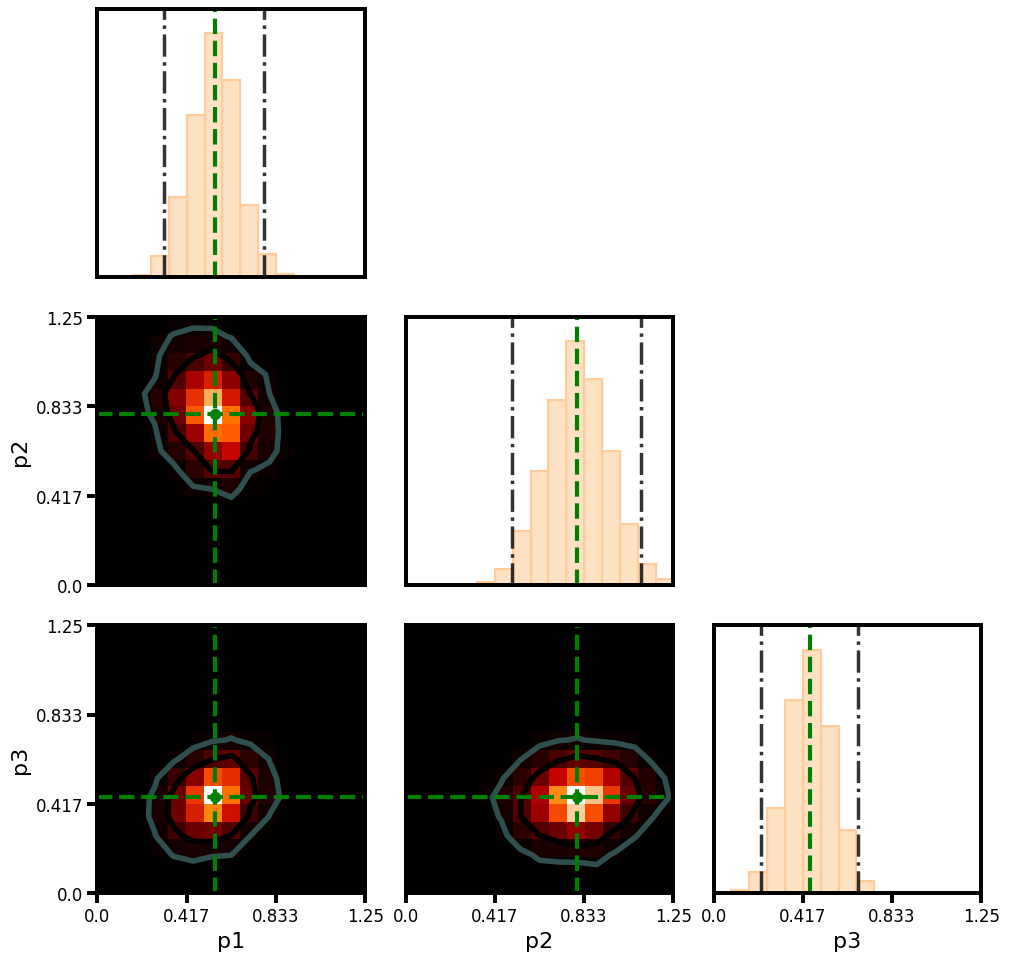

In [5]:
fig = plt.figure(1)
pdf_list = [independent_likelihood_product_from_samples]
triplot = TrianglePlot(pdf_list)
axes_list = triplot.make_triplot(truths=truths, filled_contours=False)
plt.show()

## Importance sampling
You can re-weight samples by specifying the weight_list option (default is None). The weight list must be the same length as data_list (first entry into density samples), and each element of weight_list must have len = data_list[i].shape[0] 

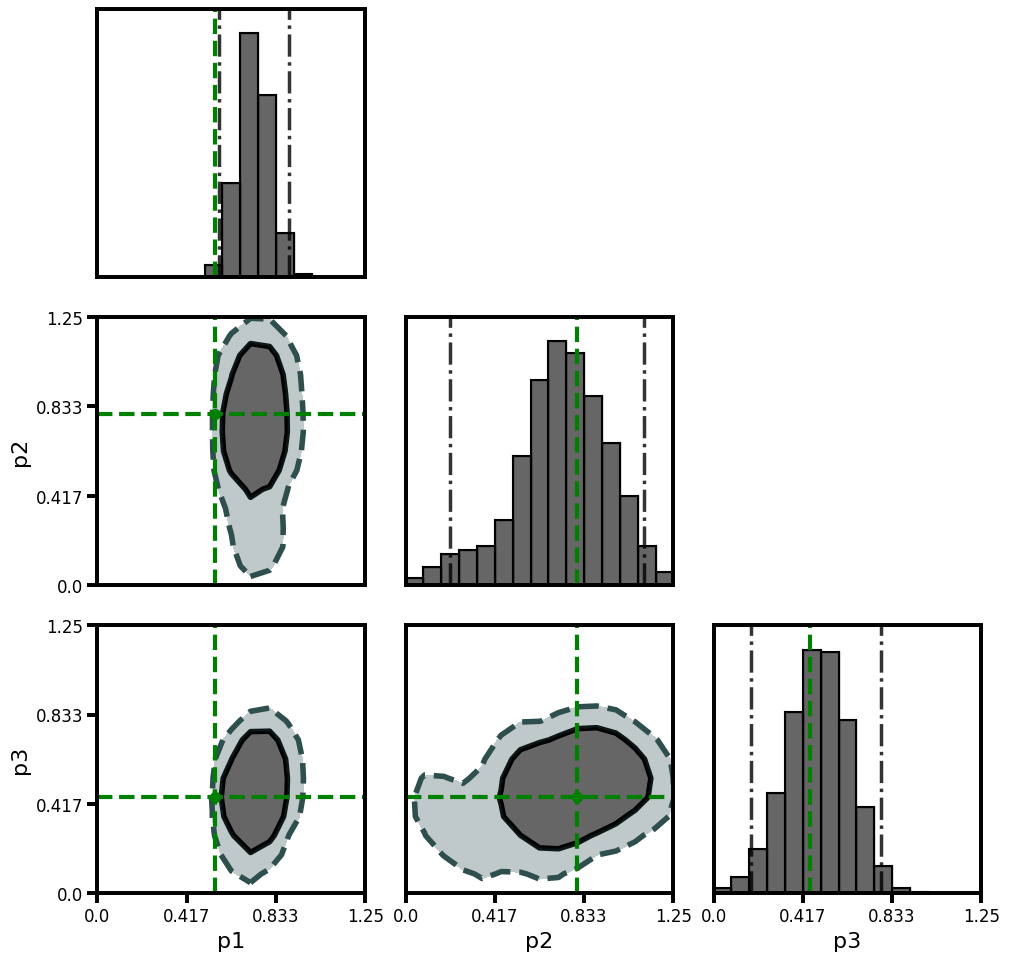

In [7]:
mu, s = means[0] + 0.2, 0.05 #offset the weights from the mean
importance_weights = np.exp(-0.5 * (mu - samples[:,0])**2 / s**2)

density_samples_with_kde = DensitySamples(samples, param_names, importance_weights, param_ranges, nbins=nbins, 
                                          use_kde=True)
independent_densities_with_kde = IndependentLikelihoods([density_samples_with_kde])

triplot = TrianglePlot([independent_densities_with_kde])
axes_list = triplot.make_triplot(truths=truths)

### Manipulating prior/posterior/likelihoods 

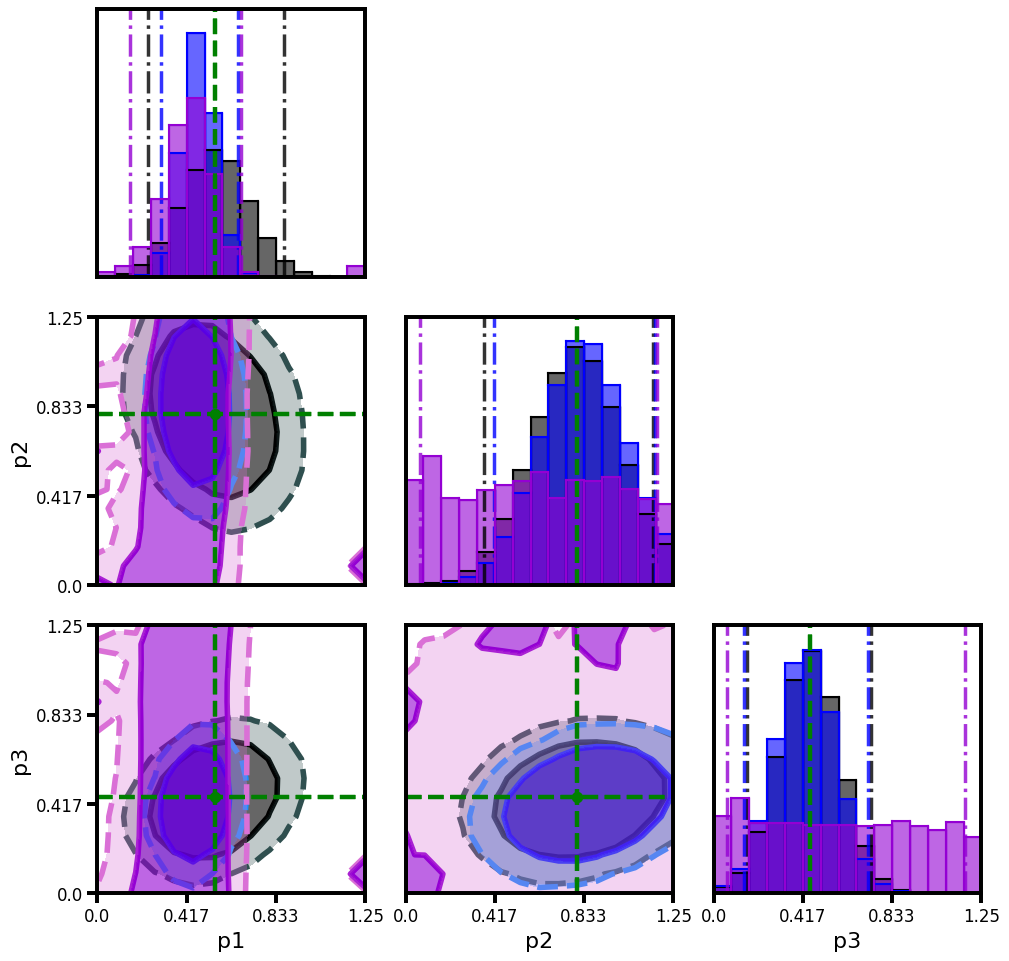

In [69]:
from copy import deepcopy 

means = [0.55, 0.8, 0.45]
sigma_11 = 0.15 ** 2
sigma_22 = 0.2 ** 2
sigma_33 = 0.12 ** 2
sigma_12 = - (0.09 ** 2)
sigma_23 = 0.08 ** 2
sigma_13 = 0.07 ** 2

cov = np.array([[sigma_11, sigma_12, sigma_13], 
       [sigma_12, sigma_22, sigma_23], 
       [sigma_13, sigma_23, sigma_33]])
nsamples = 20000
use_kde = True
nbins = 15
samples_prior = np.random.multivariate_normal(means, cov, nsamples)
prior_pdf = DensitySamples(samples_prior, param_names, None, param_ranges, 
                                        nbins=nbins, use_kde=use_kde)

weights = np.exp(-0.5 * (samples_prior[:,0] - 0.45)**2 / 0.075**2) 

posterior_pdf = DensitySamples(samples_prior, param_names,  weights, param_ranges, 
                                        nbins=nbins, use_kde=use_kde)

likelihood_pdf = deepcopy(posterior_pdf) # make a duplicate class instance
likelihood_pdf.density = posterior_pdf.density / prior_pdf.density 
inds_nan = np.isnan(likelihood_pdf.density)
likelihood_pdf.density[inds_nan] = 0

# the likelihood is a Guassian in the first parameter
prior = IndependentLikelihoods([prior_pdf])
posterior = IndependentLikelihoods([posterior_pdf])
likelihood = IndependentLikelihoods([likelihood_pdf])

triplot = TrianglePlot([prior, posterior, likelihood])
axes_list = triplot.make_triplot(truths=truths)
# magenta is the likelihood

### Computing the likelihood by sampling 

You can also calculate the likelihood from the prior/posterior by sampling, which may be more numerically stable

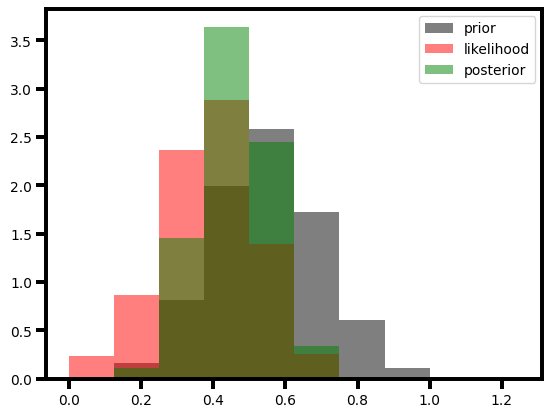

In [70]:
from trikde.pdfs import InterpolatedLikelihood

prior_interp = InterpolatedLikelihood(prior, param_names, param_ranges)
posterior_interp = InterpolatedLikelihood(posterior, param_names, param_ranges)

# now we generate samples uniformly 
n = 10000
samples_uniform = np.empty((n, 3))
samples_uniform[:,0] = np.random.uniform(param_ranges[0][0], param_ranges[0][1], n)
samples_uniform[:,1] = np.random.uniform(param_ranges[1][0], param_ranges[1][1], n)
samples_uniform[:,2] = np.random.uniform(param_ranges[2][0], param_ranges[2][1], n)

# consider just the first parameter
weights_prior = np.array([prior_interp(samples_uniform[i,:]) for i in range(0, n)])
weights_posterior = np.array([posterior_interp(samples_uniform[i,:]) for i in range(0, n)])
weights_likelihood = np.array([weights_posterior[i] / weights_prior[i] for i in range(0, n)])

# set the likelihood to zero for infinities
inds_nan = np.isnan(weights_likelihood)
weights_likelihood[inds_nan] = 0
inds_nan = np.isnan(weights_posterior)
weights_posterior[inds_nan] = 0

plt.hist(samples_prior[:,0], density=True,color='k',alpha=0.5,
         range=(param_ranges[0][0], param_ranges[0][1]),label='prior')

plt.hist(samples_uniform[:,0], weights=weights_likelihood,
         density=True,color='r',
         range=(param_ranges[0][0], param_ranges[0][1]),alpha=0.5,label='likelihood')

plt.hist(samples_uniform[:,0], weights=weights_posterior,
         density=True,color='g',
         range=(param_ranges[0][0], param_ranges[0][1]),alpha=0.5,label='posterior')

plt.legend()
plt.show()